# Implementing compartmental structures

In this notebook we demonstrate how to implement different compartmental structures.

In [1]:
from matplotlib.pyplot import subplots
from matplotlib.cm import get_cmap
from numpy import append, arange, around, array, log, where, zeros
from numpy.linalg import eig
from os import chdir, getcwd
from pandas import read_csv
from scipy.integrate import solve_ivp
from time import time as get_time
from model.common import RateEquations
from model.imports import NoImportModel
from model.preprocessing import aggregate_contact_matrix, HouseholdPopulation, ModelInput
from model.subsystems import subsystem_key

In [2]:
current_dir = getcwd()
if current_dir[-9:] == 'tutorials':
    chdir('..')

In [3]:
print(getcwd())

C:\Users\Joe Hilton\Documents\Github\covid-19-in-households-public


In [4]:
# List of observed household compositions
composition_list = array(
    [[0, 1], [0, 2], [1, 1], [1, 2], [2, 1], [2, 2]])
# Proportion of households which are in each composition
comp_dist = array([0.2, 0.2, 0.1, 0.1, 0.1,  0.1])

## SIR model

In [5]:
SIR_SPEC = {
    # Interpretable parameters:
    'AR': 0.45,                     # Secondary attack probability
    'R*': 1.1,                      # Reproduction number
    'recovery_rate': 1/4,           # Recovery rate
    'sus': array([1,1]),          # Relative susceptibility by age/vulnerability class
    'density_expo' : 0.5, # "Cauchemez parameter"
}

In [6]:
TWO_AGE_UK_SPEC = {
    'k_home': {                                                 # File location for UK within-household contact matrix
        'file_name': 'inputs/MUestimates_home_2.xlsx',
        'sheet_name':'United Kingdom of Great Britain'
    },
    'k_all': {                                                  # File location for UK pop-level contact matrix
        'file_name': 'inputs/MUestimates_all_locations_2.xlsx',
        'sheet_name': 'United Kingdom of Great Britain'
    },
    'pop_pyramid_file_name': 'inputs/United Kingdom-2019.csv',   # File location for UK age pyramid
    'fine_bds' : arange(0,81,5),                                # Boundaries used in pyramid/contact data
    'coarse_bds' : array([0,20])                                # Desired boundaries for model population
}

In [7]:
MODEL_SPEC = {**SIR_SPEC, **TWO_AGE_UK_SPEC}

In [8]:
class SIRInput(ModelInput):
    def __init__(self, spec):
        super().__init__(spec)

        fine_bds = spec['fine_bds']
        self.coarse_bds = spec['coarse_bds']
        
        pop_pyramid = read_csv(
            spec['pop_pyramid_file_name'], index_col=0)
        pop_pyramid = (pop_pyramid['F'] + pop_pyramid['M']).to_numpy()

        self.k_home = aggregate_contact_matrix(
            self.k_home, fine_bds, self.coarse_bds, pop_pyramid)
        self.k_all = aggregate_contact_matrix(
            self.k_all, fine_bds, self.coarse_bds, pop_pyramid)
        self.k_ext = self.k_all - self.k_home
        self.sus = spec['sus']
        self.inf_scales = [[1,1]] # In the SIR model there is only one infectious compartment
        
        self.inf_compartment_list = [1]
        self.no_inf_compartments = len(self.inf_compartment_list)
        
        home_eig = max(eig(

            self.sus * ((1/spec['recovery_rate']) *
             (self.k_home))

            )[0])
        ext_eig = max(eig(

            self.sus * ((1/spec['recovery_rate']) *
             (self.k_ext))

            )[0])

        R_int = - log(1 - spec['AR'])

        self.k_home = R_int * self.k_home / home_eig
        external_scale = min((spec['R*']/(2.3*spec['AR'])),2-R_int)
        self.k_ext = external_scale * self.k_ext / ext_eig
        self.density_expo = spec['density_expo']
        self.import_model = NoImportModel()

    @property
    def gamma(self):
        return self.spec['recovery_rate']

In [9]:
def initialise_SIR(
        household_population,
        rhs,
        prev=1.0e-2,
        immunity=5.6e-2,
        AR=1.0):
    '''TODO: docstring'''
    fully_sus = where(
        rhs.states_sus_only.sum(axis=1)
        ==
        household_population.states.sum(axis=1))[0]
    if immunity>0:
        already_visited = where(
            (rhs.states_rec_only.sum(axis=1)
                == around(AR*household_population.states.sum(axis=1)).astype(int)
                & ((rhs.states_sus_only + rhs.states_rec_only).sum(axis=1)
                    == household_population.states.sum(axis=1)))
            & ((rhs.states_rec_only).sum(axis=1) > 0))[0]
    # This last condition is needed to make sure we don't include any fully
    # susceptible states
    i_is_one = where(
        ((rhs.states_inf_only).sum(axis=1) == 1)
        & ((
            rhs.states_sus_only+rhs.states_inf_only).sum(axis=1)
            ==
            household_population.states.sum(axis=1))
    )[0]
    ave_hh_size = sum(
        household_population.composition_distribution.T.dot(
            household_population.composition_list))
    H0 = zeros(len(household_population.which_composition))
    inf_comps = household_population.which_composition[i_is_one]
    x = array([])
    for state in i_is_one:
        x = append(
            x,
            (1/len(inf_comps == household_population.which_composition[state]))
            * household_population.composition_distribution[
                household_population.which_composition[state]])
        # base_comp_dist[household_population.which_composition[state]]-=x[-1]
    if immunity>0:
        visited_comps = household_population.which_composition[already_visited]
        y = array([])
        for state in already_visited:
            y = append(
                y,
                (1/len(
                    visited_comps
                    == household_population.which_composition[state]))
                * household_population.composition_distribution[
                    household_population.which_composition[state]])
        # base_comp_dist[household_population.which_composition[state]]-=y[-1]
    # y = household_population.composition_distribution[
    #     household_population.which_composition[already_visited]]
    H0[i_is_one] = ave_hh_size*(prev/sum(x)) * x
    if immunity>0:
        H0[already_visited] = ave_hh_size*((immunity/AR)/sum(y)) * y
    H0[fully_sus] = (1-sum(H0)) * household_population.composition_distribution

    return H0

In [10]:
model_input = SIRInput(MODEL_SPEC)

# List of observed household compositions
composition_list = array(
    [[0, 1], [0, 2], [1, 1], [1, 2], [2, 1], [2, 2]])
# Proportion of households which are in each composition
comp_dist = array([0.2, 0.2, 0.1, 0.1, 0.1,  0.1])

household_population = HouseholdPopulation(
    composition_list, comp_dist, 'SIR', model_input)

TypeError: __init__() missing 2 required positional arguments: 'composition_list' and 'composition_distribution'

In [19]:
class SIRRateEquations(RateEquations):
    pass
    @property
    def states_inf_only(self):
        return household_population.states[:, 1::self.no_compartments]
    @property
    def states_rec_only(self):
        return household_population.states[:, 2::self.no_compartments]

In [20]:
rhs = SIRRateEquations(
    'SIR',
    model_input,
    household_population)

In [13]:
H0 = initialise_SIR(
    household_population, rhs)

In [14]:
tspan = (0.0, 90)
simple_model_start = get_time()
solution = solve_ivp(rhs, tspan, H0, first_step=0.001)
simple_model_end = get_time()

In [15]:
t = solution.t
H = solution.y

S = H.T.dot(household_population.states[:,::3])
I = H.T.dot(household_population.states[:,1::3])
R = H.T.dot(household_population.states[:,2::3])
N = S + I + R

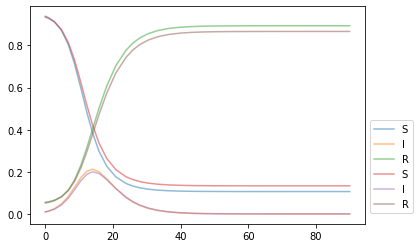

In [16]:
fig, axis = subplots(1,1, sharex=True)

cmap = get_cmap('tab20')
alpha = 0.5

for age_class in range(2):
    axis.plot(t, S[:,age_class]/N[:,age_class], label='S', alpha=alpha)
    axis.plot(t, I[:,age_class]/N[:,age_class], label='I', alpha=alpha)
    axis.plot(t, R[:,age_class]/N[:,age_class], label='R', alpha=alpha)
    axis.legend(ncol=1, bbox_to_anchor=(1,0.50))

In [21]:
print(rhs.states_rec_only)

[[0. 1.]
 [0. 0.]
 [0. 0.]
 [0. 2.]
 [0. 1.]
 [0. 0.]
 [0. 1.]
 [0. 0.]
 [0. 0.]
 [1. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 0.]
 [0. 0.]
 [1. 0.]
 [0. 0.]
 [0. 0.]
 [1. 2.]
 [0. 2.]
 [0. 2.]
 [1. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 0.]
 [0. 0.]
 [1. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 0.]
 [0. 0.]
 [1. 0.]
 [0. 0.]
 [0. 0.]
 [2. 1.]
 [1. 1.]
 [0. 1.]
 [1. 1.]
 [0. 1.]
 [0. 1.]
 [2. 0.]
 [1. 0.]
 [0. 0.]
 [1. 0.]
 [0. 0.]
 [0. 0.]
 [2. 0.]
 [1. 0.]
 [0. 0.]
 [1. 0.]
 [0. 0.]
 [0. 0.]
 [2. 2.]
 [1. 2.]
 [0. 2.]
 [1. 2.]
 [0. 2.]
 [0. 2.]
 [2. 1.]
 [1. 1.]
 [0. 1.]
 [1. 1.]
 [0. 1.]
 [0. 1.]
 [2. 0.]
 [1. 0.]
 [0. 0.]
 [1. 0.]
 [0. 0.]
 [0. 0.]
 [2. 1.]
 [1. 1.]
 [0. 1.]
 [1. 1.]
 [0. 1.]
 [0. 1.]
 [2. 0.]
 [1. 0.]
 [0. 0.]
 [1. 0.]
 [0. 0.]
 [0. 0.]
 [2. 0.]
 [1. 0.]
 [0. 0.]
 [1. 0.]
 [0. 0.]
 [0. 0.]]
